In [1]:
import pandas as pd
import re
from transformers import pipeline
from datasets import Dataset
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import logging
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from PIL import Image

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

## Завантаження та огляд даних

In [2]:
# Завантажуємо текстові дані
train_data = pd.read_csv('/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-10/train.csv')
test_data = pd.read_csv('/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-10/test.csv')

train_data.head()

,PetID,Description,AdoptionSpeed
0,d3b4f29f8,Mayleen and Flo are two lovely adorable sister...,2
1,e9dc82251,A total of 5 beautiful Tabbys available for ad...,2
2,8111f6d4a,Two-and-a-half month old girl. Very manja and ...,2
3,693a90fda,Neil is a healthy and active ~2-month-old fema...,2
4,9d08c85ef,Gray kitten available for adoption in sungai p...,2


In [3]:
train_data.info()
train_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6431 entries, 0 to 6430
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   PetID          6431 non-null   object
 1   Description    6426 non-null   object
 2   AdoptionSpeed  6431 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 150.9+ KB


(6431, 3)

In [4]:
# Завантажуємо зображення
train_image_dir = '/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-10/images/images/train'
test_image_dir = '/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-10/images/images/test'

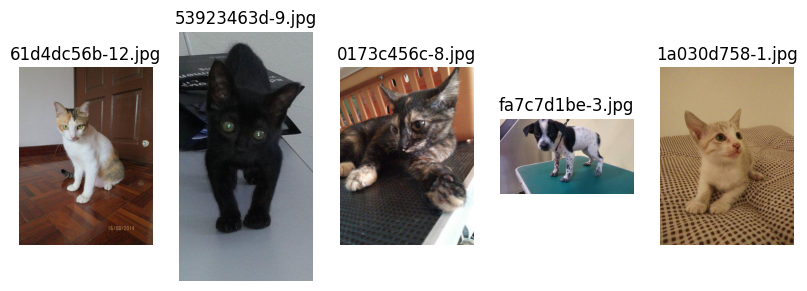

In [5]:
# Переглядаємо зображення
def load_and_show_images(image_dir, num_images=5):
    image_files = os.listdir(image_dir)[:num_images]
    plt.figure(figsize=(10, 10))
    
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(image_dir, image_file)
        img = Image.open(img_path)
        
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(image_file)
        plt.axis('off')
    
    plt.show()

load_and_show_images(train_image_dir)

In [6]:
# Розміри зображень
def check_image_sizes(image_dir, num_images=5):
    image_files = os.listdir(image_dir)[:num_images]
    for image_file in image_files:
        img_path = os.path.join(image_dir, image_file)
        img = Image.open(img_path)
        print(f"Size of {image_file}: {img.size}")

check_image_sizes(train_image_dir)

Size of 61d4dc56b-12.jpg: (300, 400)
Size of 53923463d-9.jpg: (343, 640)
Size of 0173c456c-8.jpg: (360, 480)
Size of fa7c7d1be-3.jpg: (640, 360)
Size of 1a030d758-1.jpg: (360, 480)


In [7]:
# Кількість каналів у зображеннях
def check_image_mode(image_dir, num_images=5):
    image_files = os.listdir(image_dir)[:num_images]
    for image_file in image_files:
        img_path = os.path.join(image_dir, image_file)
        img = Image.open(img_path)
        print(f"Mode of {image_file}: {img.mode}")

check_image_mode(train_image_dir)

Mode of 61d4dc56b-12.jpg: RGB
Mode of 53923463d-9.jpg: RGB
Mode of 0173c456c-8.jpg: RGB
Mode of fa7c7d1be-3.jpg: RGB
Mode of 1a030d758-1.jpg: RGB


In [8]:
# Розподіл цільової зміної
train_data['AdoptionSpeed'].value_counts()

AdoptionSpeed
4    2133
2    1773
3    1328
1    1197
Name: count, dtype: int64

## Попередня обробка даних

In [9]:
# Функція для попередньої обробки тексту
def preprocess_text(text):
    text = text.lower()  # Перетворюємо текст у нижній регістр
    text = text.strip()  # Видаляємо зайві пробіли
    text = re.sub(r'[^a-z\s]', '', text)  # Видаляємо спеціальні символи та цифри
    return text[:512]  # Обрізаємо текст до 512 символів

train_data['Description'] = train_data['Description'].fillna('').apply(preprocess_text)
test_data['Description'] = test_data['Description'].fillna('').apply(preprocess_text)

In [10]:
# Створюємо об'єкти Dataset
train_dataset = Dataset.from_pandas(train_data[['Description']])
test_dataset = Dataset.from_pandas(test_data[['Description']])

In [11]:
# Ініціалізуємо pipeline для аналізу емоцій з BERT
sentiment_analyzer = pipeline('sentiment-analysis', 
                              model="distilbert-base-uncased-finetuned-sst-2-english", 
                              device=0)

# Застосуємо аналіз емоцій до кожного запису
def analyze_sentiment_batch(batch):
    results = sentiment_analyzer(batch['Description'], truncation=True)
    batch['sentiment_label'] = [result['label'] for result in results]
    batch['sentiment_score'] = [result['score'] for result in results]
    return batch

train_dataset = train_dataset.map(analyze_sentiment_batch, batched=True, batch_size=16)
test_dataset = test_dataset.map(analyze_sentiment_batch, batched=True, batch_size=16)

# Перетворюємо Dataset у DataFrame та додаємо до основних даних
train_data['sentiment_label'] = train_dataset['sentiment_label']
train_data['sentiment_score'] = train_dataset['sentiment_score']

test_data['sentiment_label'] = test_dataset['sentiment_label']
test_data['sentiment_score'] = test_dataset['sentiment_score']

print("Семантичний аналіз даних завершено!")

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Map:   0%|          | 0/6431 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Map:   0%|          | 0/1891 [00:00<?, ? examples/s]

Семантичний аналіз даних завершено!


In [12]:
train_data.head()

,PetID,Description,AdoptionSpeed,sentiment_label,sentiment_score
0,d3b4f29f8,mayleen and flo are two lovely adorable sister...,2,POSITIVE,0.999137
1,e9dc82251,a total of beautiful tabbys available for ado...,2,POSITIVE,0.976065
2,8111f6d4a,twoandahalf month old girl very manja and cute,2,POSITIVE,0.999378
3,693a90fda,neil is a healthy and active monthold female k...,2,POSITIVE,0.999683
4,9d08c85ef,gray kitten available for adoption in sungai p...,2,NEGATIVE,0.887429


In [13]:
# Функція для завантаження та підготовки зображення
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

model = DenseNet121(weights='imagenet', include_top=False, pooling='max')

# Функція для витягування ознак з зображень
def extract_image_features(image_dir, pet_ids):
    features = []
    logger = tf.get_logger()
    original_log_level = logger.level
    logger.setLevel(logging.ERROR)

    for pet_id in tqdm(pet_ids, desc="Витягування ознак зображень"):
        image_path = os.path.join(image_dir, pet_id + '-1.jpg')
        if os.path.exists(image_path):
            img = load_and_preprocess_image(image_path)
            img_features = model.predict(img, verbose=0)
            features.append(img_features.flatten())
        else:
            features.append(np.zeros(1024))

    logger.setLevel(original_log_level)
    return np.array(features)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# Отримуємо ознаки із зображень
train_image_features = extract_image_features(train_image_dir, train_data['PetID'])
test_image_features = extract_image_features(test_image_dir, test_data['PetID'])

Витягування ознак зображень:   0%|          | 0/6431 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1730290863.380526     138 service.cc:145] XLA service 0x7e9fcc080990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730290863.380584     138 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730290870.549591     138 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Витягування ознак зображень: 100%|██████████| 1891/1891 [02:31<00:00, 12.48it/s]


In [15]:
# Об'єднуємо текстові та візуальні ознаки для тренувальних і тестових даних
train_data_combined = pd.concat([train_data.reset_index(drop=True), pd.DataFrame(train_image_features)], axis=1)
test_data_combined = pd.concat([test_data.reset_index(drop=True), pd.DataFrame(test_image_features)], axis=1)

## Побудова моделі

In [16]:
# Розділяємо тренувальні дані на тренувальний та валідаційний набори
X = train_data_combined.drop(columns=['AdoptionSpeed', 'PetID', 'Description', 'sentiment_label' ])
y = train_data_combined['AdoptionSpeed']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Тренувальний набір: {X_train.shape}")
print(f"Валідаційний набір: {X_val.shape}")

Тренувальний набір: (5144, 1025)
Валідаційний набір: (1287, 1025)


In [17]:
# Перетворимо індекси AdoptionSpeed, щоб починались з 0
y_train = y_train - 1
y_val = y_val - 1

In [18]:
# Створюємо DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [19]:
# Параметри XGBoost
params = {
    'objective': 'multi:softmax',  # Для класифікації
    'num_class': 4,  # Класи 0-3 для AdoptionSpeed
    'eval_metric': ['mlogloss', 'merror'],  # Логарифмічна втрата і похибка класифікації
    'max_depth': 6,  # Глибина дерев
    'eta': 0.01,  # Коефіцієнт навчання
    'subsample': 0.8,  # Вибірка частини даних для кожного дерева
    'colsample_bytree': 0.8,  # Вибірка частини ознак для кожного дерева
    'min_child_weight': 1,  # Мінімальна кількість спостережень у листі
    'alpha': 0.1,  # L1-регуляризація
    'lambda': 1.0,  # L2-регуляризація
    'seed': 42  # Для стабільності результатів
}

# Створюємо словник для логування втрат і точності
evals_result = {}

# Тренуємо модель з найкращими параметрами
evallist = [(dtrain, 'train'), (dval, 'eval')]

In [20]:
# Тренуємо модель
bst = xgb.train(params, dtrain, num_boost_round=100, evals=evallist, early_stopping_rounds=10, evals_result=evals_result, verbose_eval=True)

# Передбачення на валідаційному наборі
y_val_pred = bst.predict(dval)

# Оцінка моделі на валідаційному наборі
kappa_score = cohen_kappa_score(y_val, y_val_pred, weights='quadratic')
print(f"Quadratic Weighted Kappa на валідаційних даних: {kappa_score}")

[0]	train-mlogloss:1.38184	train-merror:0.41932	eval-mlogloss:1.38484	eval-merror:0.64646
[1]	train-mlogloss:1.37744	train-merror:0.34428	eval-mlogloss:1.38300	eval-merror:0.63092
[2]	train-mlogloss:1.37326	train-merror:0.30754	eval-mlogloss:1.38150	eval-merror:0.60761
[3]	train-mlogloss:1.36895	train-merror:0.26983	eval-mlogloss:1.38012	eval-merror:0.59596
[4]	train-mlogloss:1.36482	train-merror:0.25039	eval-mlogloss:1.37892	eval-merror:0.58586
[5]	train-mlogloss:1.36054	train-merror:0.24281	eval-mlogloss:1.37752	eval-merror:0.58508
[6]	train-mlogloss:1.35641	train-merror:0.23425	eval-mlogloss:1.37597	eval-merror:0.58042
[7]	train-mlogloss:1.35226	train-merror:0.22609	eval-mlogloss:1.37448	eval-merror:0.57110
[8]	train-mlogloss:1.34805	train-merror:0.21267	eval-mlogloss:1.37306	eval-merror:0.57653
[9]	train-mlogloss:1.34381	train-merror:0.20587	eval-mlogloss:1.37167	eval-merror:0.57809
[10]	train-mlogloss:1.33984	train-merror:0.20451	eval-mlogloss:1.37053	eval-merror:0.57731
[11]	trai

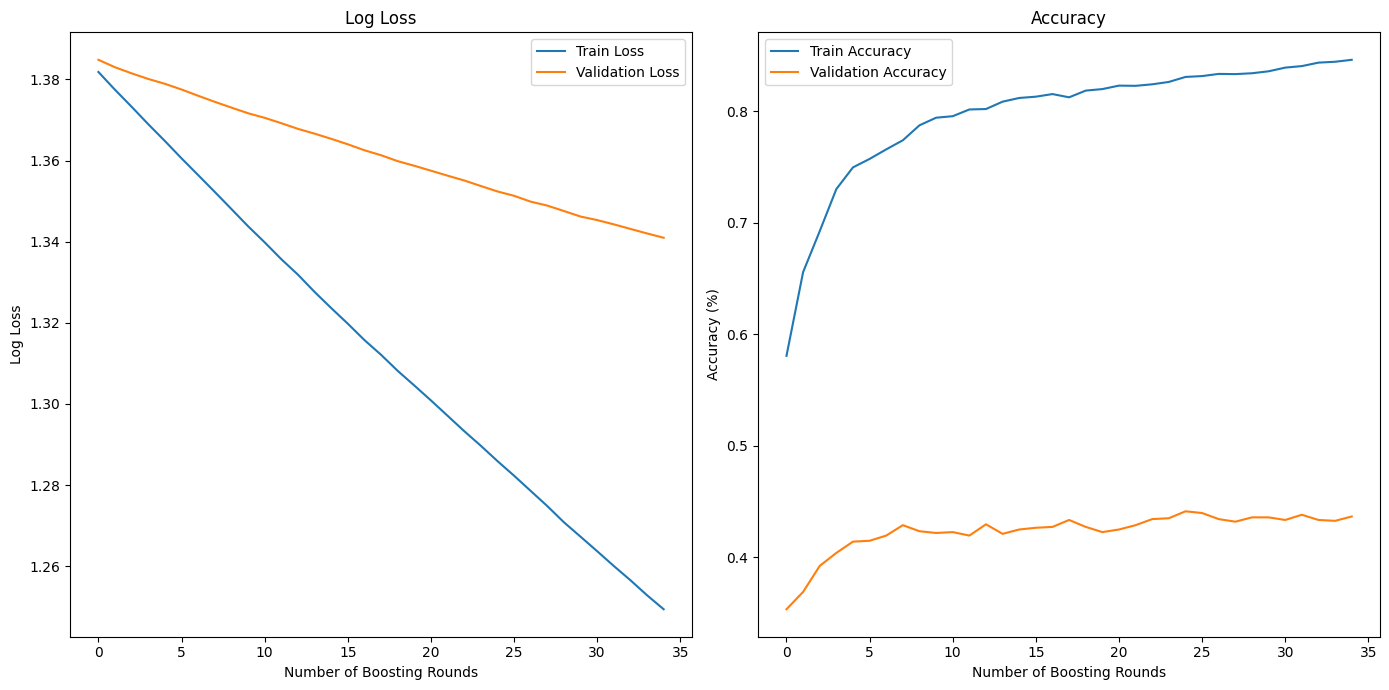

In [21]:
# Побудова графіків втрат і точності
epochs = len(evals_result['train']['mlogloss'])
x_axis = range(0, epochs)

# Графік втрат і точності
plt.figure(figsize=(14, 7))

# Графік втрат
plt.subplot(1, 2, 1)
plt.plot(x_axis, evals_result['train']['mlogloss'], label='Train Loss')
plt.plot(x_axis, evals_result['eval']['mlogloss'], label='Validation Loss')
plt.title('Log Loss')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Log Loss')
plt.legend()

# Графік точності (accuracy)
plt.subplot(1, 2, 2)
plt.plot(x_axis, [1 - e for e in evals_result['train']['merror']], label='Train Accuracy')
plt.plot(x_axis, [1 - e for e in evals_result['eval']['merror']], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Створюємо об'єкт DMatrix для тестових даних
dtest = xgb.DMatrix(test_data_combined.drop(columns=['PetID', 'Description', 'sentiment_label']))

# Передбачаємо швидкість всиновлення на тестовому наборі
test_preds = bst.predict(dtest)

# Зміщуємо на +1, щоб повернути класи у діапазон 1-4
test_preds = test_preds + 1

# Формуємо DataFrame з результатами
submission = pd.DataFrame({
    'PetID': test_data['PetID'],
    'AdoptionSpeed': test_preds.astype(int)
})

# Зберігаємо результати у файл CSV для завантаження
submission.to_csv('/kaggle/working/submission.csv', index=False)

print("Файл submission.csv успішно створений!")

Файл submission.csv успішно створений!
